# Inspect TF Records

In [1]:
import sys
print(sys.executable, sys.version)

import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf 

# for local import 
sys.path.append(os.path.abspath('..'))

from src.main.config import Config
from utils import draw_skeleton

/home/mmc-user/.virtualenvs/hmr2.0/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


### parse tf records example proto

In [7]:
def parse_test(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64),
        'sequence': tf.io.FixedLenFeature([], dtype=tf.string)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']
    sequence = features['sequence']
    return image, kp2d, kp3d, has_3d, sequence

def parse(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)

    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']

    return image, kp2d, kp3d, has_3d

In [8]:
def show_image(image, kp2d, vis):
    image = draw_skeleton(image, kp2d, vis=vis)
    plt.imshow(image)
    plt.show()

### show train/val examples 

In [9]:
def read_train_tfrecords(path):
    dataset = tf.data.TFRecordDataset(path).map(parse)
    for x in dataset.take(10):
        image, kp2d, kp3d, has_3d = x[0], x[1], x[2], x[3]
        
        print('has3d: ', has_3d.numpy().astype(bool))
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])

has3d:  True


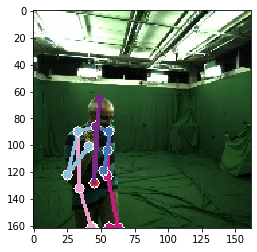

has3d:  True


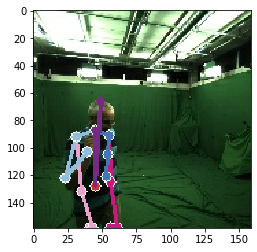

has3d:  True


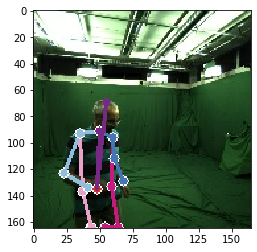

has3d:  True


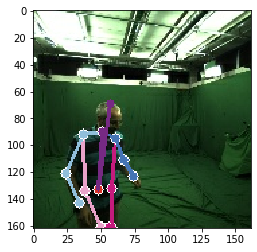

has3d:  True


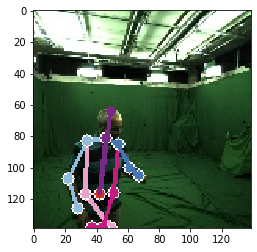

has3d:  True


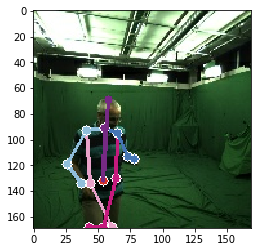

has3d:  True


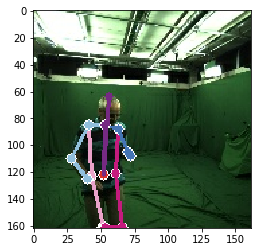

has3d:  True


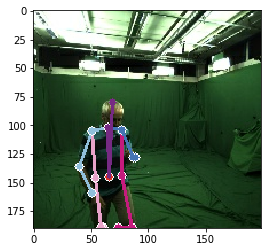

has3d:  True


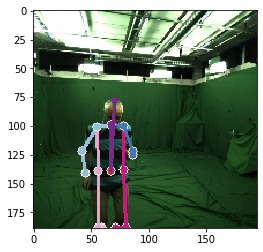

has3d:  True


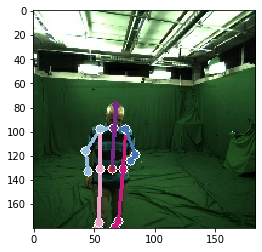

In [10]:
path = os.path.join("/data/ssd1/russales/new_records/mpii_3d", "329_train.tfrecord")
read_train_tfrecords(path)

### show test examples

In [11]:
def read_test_tfrecords(path):    
    dataset = tf.data.TFRecordDataset(path).map(parse_test)
    for image, kp2d, kp3d, has3d, sequence in dataset.take(10):
        print('sequence: ', sequence.numpy().decode('utf-8'))
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])    

sequence:  mpii_ts1


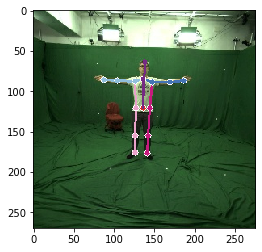

sequence:  mpii_ts1


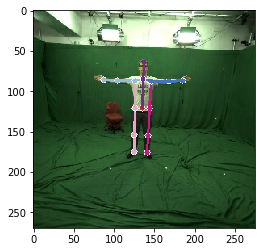

sequence:  mpii_ts1


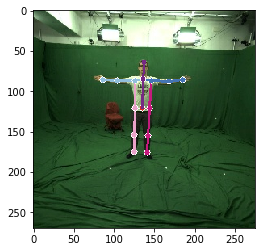

sequence:  mpii_ts1


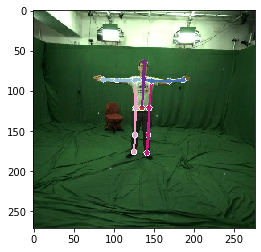

sequence:  mpii_ts1


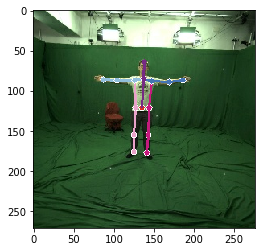

sequence:  mpii_ts1


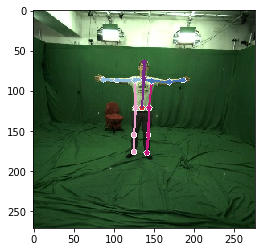

sequence:  mpii_ts1


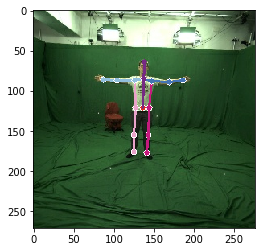

sequence:  mpii_ts1


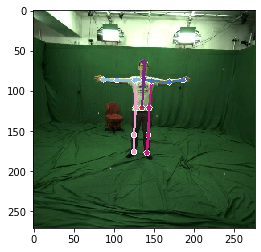

sequence:  mpii_ts1


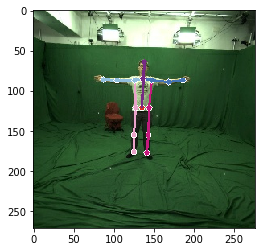

sequence:  mpii_ts1


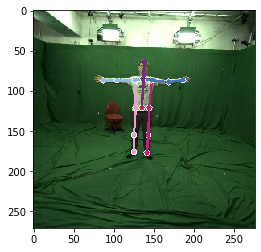

In [12]:
path = os.path.join("/data/ssd1/russales/new_records/mpii_3d", "347_test.tfrecord")
read_test_tfrecords(path)

## Inspect Dataset Splits (train/val/test)

In [15]:
class CountConfig(Config):
    ROOT_DIR = os.path.join('/', 'data', 'ssd1', 'russales')
    DATA_DIR = os.path.join(ROOT_DIR, 'new_records')

def count_train_val_samples(split='train'):
    config = CountConfig()

    tf_record_dirs = [os.path.join(config.DATA_DIR, dataset, '*_{}.tfrecord'.format(split)) for dataset in config.DATASETS]
    tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]

    def parse(example_proto):
        feature_map = {
            'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
            'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
            'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
            'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        has_3d = features['has_3d']
        return has_3d
    
    dataset = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
        .map(parse, num_parallel_calls=config.NUM_PARALLEL) \
        .prefetch(config.NUM_PARALLEL * 2)

    num_samples, num_3d_samples, num_2d_samples = 0, 0, 0
    for has_3d in dataset:
        if has_3d:
            num_3d_samples += 1
        else:
            num_2d_samples += 1
        num_samples += 1
    print('Total number of samples in tf records: ', num_samples)
    print('3d samples: {} - 2d samples: {}'.format(num_3d_samples, num_2d_samples))

    
def count_test_samples():
    config = CountConfig()

    tf_record_dirs = [os.path.join(config.DATA_DIR, dataset, '*_test.tfrecord') for dataset in config.DATASETS]
    tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]
    
    def parse_test(example_proto):
        feature_map = {
            'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
            'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
            'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
            'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64),
            'sequence': tf.io.FixedLenFeature([], dtype=tf.string)
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        sequence = features['sequence']
        return sequence

    dataset = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
        .map(parse_test, num_parallel_calls=config.NUM_PARALLEL) \
        .prefetch(config.NUM_PARALLEL * 2)
    
    num_samples, sequence_count = 0, {}
    for sequence in dataset:
        sequence = sequence.numpy().decode("utf-8")
        if sequence not in sequence_count.keys():
            sequence_count[sequence] = 1
        else:
            sequence_count[sequence] += 1
        num_samples += 1

    print('Total number of samples in tf records: ', num_samples)
    import json
    print(json.dumps(sequence_count, indent=4, sort_keys=True))

In [17]:
count_train_val_samples()
print('============================================\n')
count_train_val_samples('val')
print('============================================\n')
count_test_samples()

Total number of samples in tf records:  425334
3d samples: 280213 - 2d samples: 145121

Total number of samples in tf records:  11921
3d samples: 6120 - 2d samples: 5801

Total number of samples in tf records:  43284
{
    "h36m_sub11_Directions 1_cam54138969": 59,
    "h36m_sub11_Directions 1_cam55011271": 59,
    "h36m_sub11_Directions 1_cam58860488": 59,
    "h36m_sub11_Directions 1_cam60457274": 59,
    "h36m_sub11_Directions_cam54138969": 69,
    "h36m_sub11_Directions_cam55011271": 69,
    "h36m_sub11_Directions_cam58860488": 69,
    "h36m_sub11_Directions_cam60457274": 69,
    "h36m_sub11_Discussion 1_cam54138969": 104,
    "h36m_sub11_Discussion 1_cam55011271": 104,
    "h36m_sub11_Discussion 1_cam58860488": 105,
    "h36m_sub11_Discussion 1_cam60457274": 104,
    "h36m_sub11_Discussion 2_cam54138969": 109,
    "h36m_sub11_Discussion 2_cam55011271": 109,
    "h36m_sub11_Discussion 2_cam58860488": 109,
    "h36m_sub11_Discussion 2_cam60457274": 109,
    "h36m_sub11_Eating 1_cam5

### serialize example proto

In [25]:
def print_example(path):
    raw_dataset = tf.data.TFRecordDataset([path])

    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

In [26]:
path = os.path.join("/data/ssd1/russales/new_records/mpii_3d", "347_test.tfrecord")
print_example(path)

features {
  feature {
    key: "has_3d"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\016\001\024\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Q